This notebooks is available at: https://github.com/Cryoris/qiskit-presentations

Then navigate to the folder: `2022-04-09_ETH_Optimization_Challenge`.

# Challenge Recap

We have a set of $n$ mountains with heights $h_i$ and hiking distances $d_i$. We calculate the time it takes for a single mountain ascent as
$$
    t_i = \frac{h_i}{M / 2} + \frac{d_i}{5M},
$$
where $M$ is a motivation factor (typically at 1000!).

The optimization problem is to find a selection $S \subset \{1, ..., n \}$ such that the combined hiking time are as close as possible to a target time $T$:
$$
    \min_{\vec x \in \{0, 1\}^n} (T - \vec x^T \vec t)^2.
$$

In this challenge we solve this problem on a quantum computer using a quantum algorithm. The grading is based mainly on two criteria:
1. With which likelihood do you find the optimal solution?
2. What's the minimal amount of quantum resources you need for your solution?

"Quantum resources" are measured as total number of CX applications after your final circuit is mapped to the quantum computer `ibmq_quito`. The total number of CX applications is determined as the number of CX in your circuits, times the number of shots, times the number of times you have to execute the circuit.

## Deliverable

A max. 2-slides presentation containing the algorithm you used and the two judging criteria:
* with which probability you found the optimal solution
* the total number of CX applications


## Tutorial requirements

In [66]:
# !pip install numpy matplotlib
# !pip install --upgrade qiskit

# The Ice Cream Problem

### Oh god, the choices! 

You've narrowed it down to 3 choices: Vanilla, Basil Strawberry and Blueberry Gum.

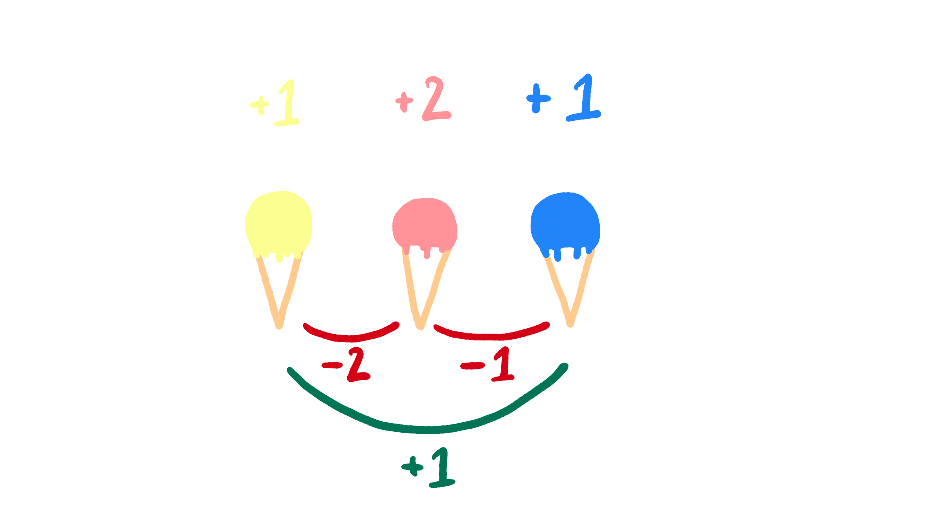


What's the optimal choice of ice creams to maximize your experience?

Side note: This problem occurs in a more serious setting in finance!

In [1]:
def ice_cream_cost(x):
    single_joys = x[0] + 2 * x[1] + x[2]
    interactions = -2 * x[0] * x[1] + x[0] * x[2] - x[1] * x[2]
    return single_joys + interactions

In [2]:
import itertools

values = []
print("x, cost")
for x in itertools.product([0, 1], repeat=3):
    values.append((x, ice_cream_cost(x)))
    print(*values[-1])

optimal = max(values, key=lambda value: value[1])
print("Optimal solution:", *optimal)

x, cost
(0, 0, 0) 0
(0, 0, 1) 1
(0, 1, 0) 2
(0, 1, 1) 2
(1, 0, 0) 1
(1, 0, 1) 3
(1, 1, 0) 1
(1, 1, 1) 2
Optimal solution: (1, 0, 1) 3


## Translating the optimization for a Quantum Computer

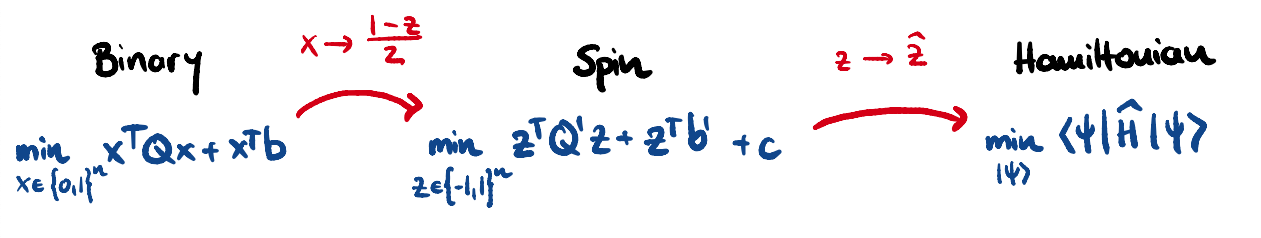

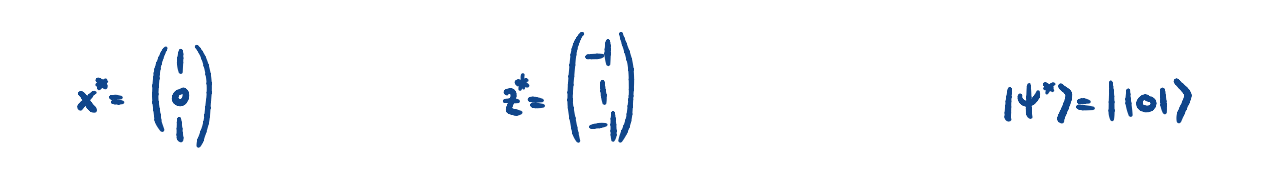

Our objective is:

$$
C(x) = x_0 + 2 x_1 + x_2 - 2 x_0 x_1 + x_0 x_2 - x_1 x_2.
$$

Replacing $x_i$ by $\frac{1 - z_i}{2}$ we multiplying everyting out, we get

$$
C(z) = \frac{3}{2} - \frac{1}{4}(z_0 + z_1 - 2z_2) - \frac{1}{4}(2 z_0z_1 - z_0 z_2 + z_1 z_2),
$$

and from there we obtain our Ising Hamiltonian
$$
\hat H = \frac{3}{2} \hat I - \frac{1}{4}(\hat Z_0 + \hat Z_1 - 2 \hat Z_2) - \frac{1}{4}(2 \hat Z_0 \hat Z_1 - \hat Z_0 \hat Z_2 +\hat Z_1 \hat Z_2)
$$


In [3]:
def spin_ice_cream_cost(z):
    return 3 / 2 - 1 / 4 * (z[0] + z[1] + 2 * z[2]) - 1 / 4 * (2 * z[0] * z[1] - z[0] * z[2] + z[1] * z[2])

spin_values = []
print("z, cost")
for z in itertools.product([-1, 1], repeat=3):
    spin_values.append((z, spin_ice_cream_cost(z)))
    print(*spin_values[-1])

spin_optimal = max(spin_values, key=lambda value: value[1])
print("Optimal solution:", *spin_optimal)

z, cost
(-1, -1, -1) 2.0
(-1, -1, 1) 1.0
(-1, 1, -1) 3.0
(-1, 1, 1) 1.0
(1, -1, -1) 2.0
(1, -1, 1) 2.0
(1, 1, -1) 1.0
(1, 1, 1) 0.0
Optimal solution: (-1, 1, -1) 3.0


Let's construct the Hamiltonian in Qiskit!

Option 1 is to use Paulis themselves:

In [4]:
from qiskit.opflow import Z, I

(Z ^ I) + (I ^ Z)

PauliSumOp(SparsePauliOp(['ZI', 'IZ'],
              coeffs=[1.+0.j, 1.+0.j]), coeff=1.0)

But than becomes cumbersome very quickly! Instead you can also use an index-based notation

In [5]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp

sparse = SparsePauliOp.from_sparse_list([
    ("", [], 3 / 2),
    ("Z", [0], -1 / 4),
    ("Z", [1], -1 / 4),
    ("Z", [2], -1 / 2),
    ("ZZ", [0, 1], -1 / 2),
    ("ZZ", [0, 2], 1 / 4),
    ("ZZ", [1, 2], -1 / 4)
], num_qubits=3)

H = PauliSumOp(sparse)
print(H)

1.5 * III
- 0.25 * IIZ
- 0.25 * IZI
- 0.5 * ZII
- 0.5 * IZZ
+ 0.25 * ZIZ
- 0.25 * ZZI


Before solving this on a quantum computer, let's make sure that the Hamiltonian we derived is correct:

In [6]:
H.to_matrix()

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 3.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j]])

First, we use an exact classical solver:

In [7]:
from qiskit.algorithms import NumPyMinimumEigensolver

exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(-H)

In [8]:
exact.eigenstate

VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2)), coeff=1.0, is_measurement=False)

In [9]:
statevector = exact.eigenstate.primitive
print("Optimal state from Hamiltonian:")
print(statevector.probabilities_dict())
print("Value:")
print(-exact.eigenvalue)

print("\nCompare to orignal solution:")
print(optimal)

Optimal state from Hamiltonian:
{'101': 1.0}
Value:
(3-0j)

Compare to orignal solution:
((1, 0, 1), 3)


## Variational Quantum Eigensolver

How can we find the minimum on a quantum computer? See [Peruzzo et al. 2014](https://www.nature.com/articles/ncomms5213#citeas).

Some help:
* [introduction to VQE](https://towardsdatascience.com/the-variational-quantum-eigensolver-explained-adcbc9659c3a)
* [Qiskit's VQE tutorial](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html)

$$
\min_{|\psi\rangle} E = \min_{|\psi\rangle} \langle\psi|\hat H|\psi\rangle
$$

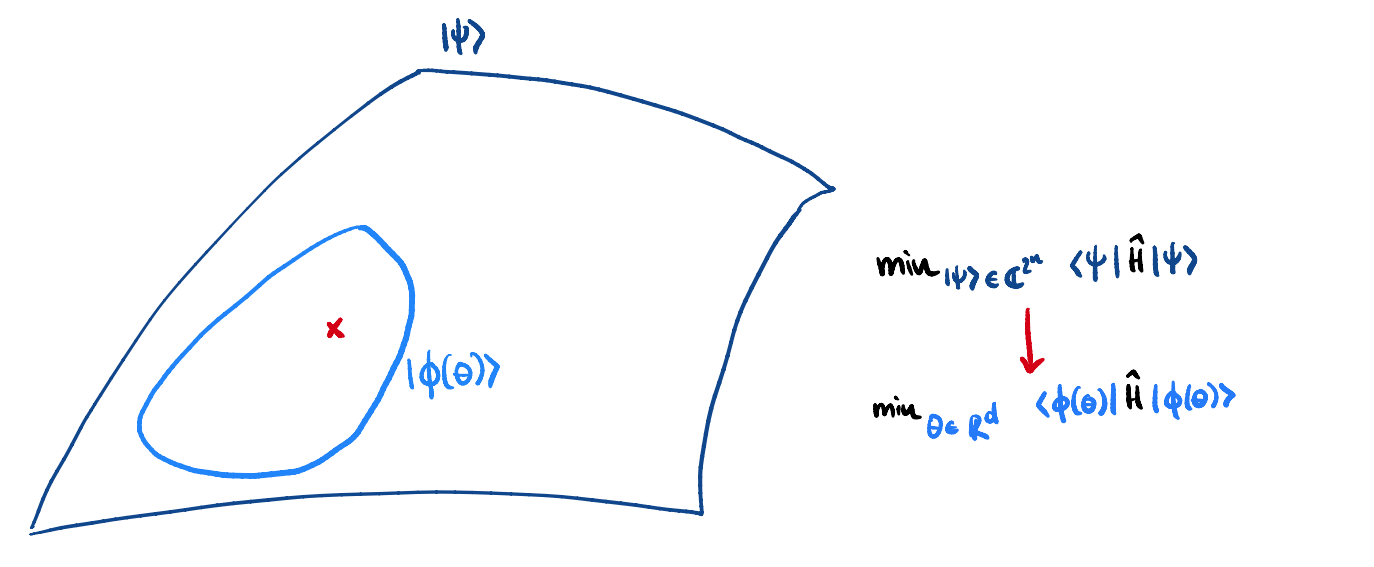

The model for us is a parameterized quantum circuit $U(\theta)$ preparing a state $|\phi(\theta)\rangle = U(\theta)|0\rangle$:

$$
\begin{aligned}
\theta^* &= \arg\min_{\theta \in \mathbb R^d} E(\theta) \\
         &= \arg\min_{\theta \in \mathbb R^d} \langle\phi(\theta)|\hat H|\phi(\theta)\rangle
\end{aligned}
$$

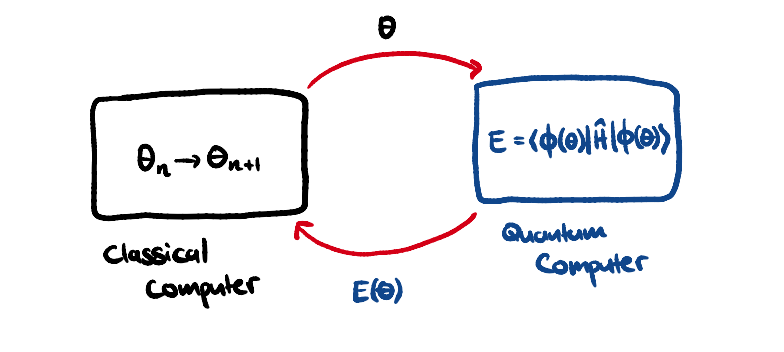

In [10]:
hamiltonian = -H

But which ansatz should we choose?

#### Hardware efficient circuits

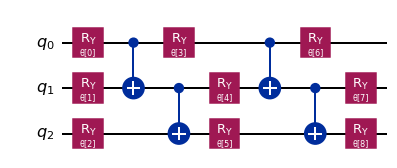

In [11]:
from qiskit.circuit.library import RealAmplitudes

hw_efficient = RealAmplitudes(num_qubits=3, reps=2, entanglement="linear")
hw_efficient.decompose().draw("mpl", style="iqx")

#### Physically motivated circuits

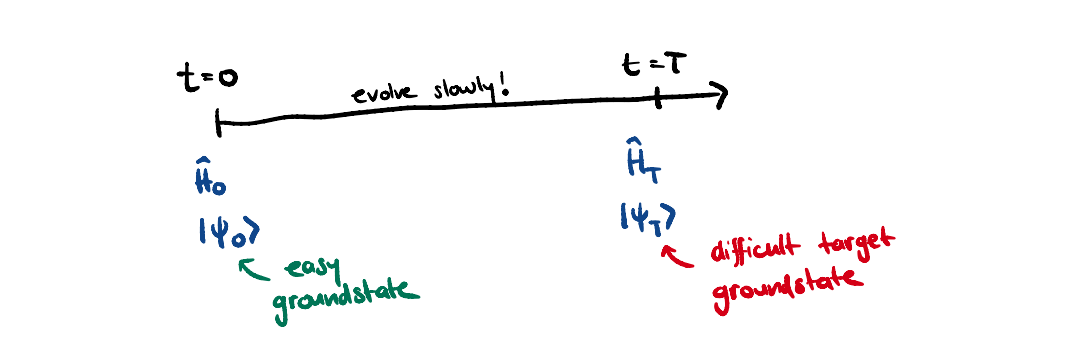

For optimization we start in

$$
\hat H_0 = -X^{\otimes n}, |\psi_0\rangle = |+\rangle^{\otimes n}
$$

and end in $\hat H_T = \hat H$ (our Ising Hamiltonian). Using this is the Quantum Approximate Optimization Algorithm (QAOA), see [Farhi et al. 2014](https://arxiv.org/abs/1411.4028). 

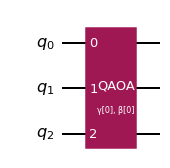

In [12]:
from qiskit.circuit.library import QAOAAnsatz

qaoa = QAOAAnsatz(hamiltonian, reps=1)
qaoa.draw("mpl", style="iqx")

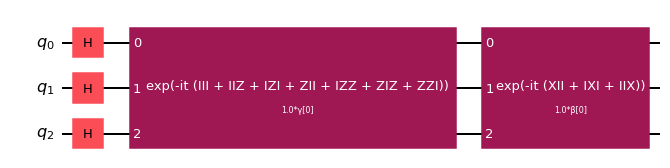

In [13]:
qaoa.decompose().draw("mpl", style="iqx")

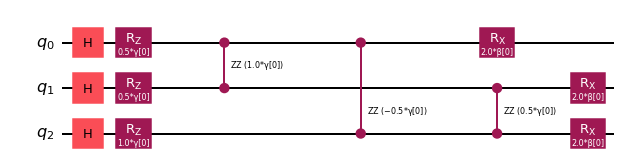

In [14]:
from qiskit import transpile

transpile(qaoa, basis_gates=["h", "rx", "rz", "rzz"]).draw("mpl", style="iqx")

### Evaluating the energy

In [15]:
from qiskit.circuit import QuantumCircuit
from qiskit.opflow import Z, X

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.s(0)
circuit.cx(0, 1)

observable = (X ^ X) + (Z ^ Z)

#### Statevector simulation

In [16]:
from qiskit.quantum_info import Statevector

Statevector(circuit).expectation_value(observable.primitive)

(0.9999999999999998+0j)

In [19]:
import numpy as np

def exact_energy(theta):
    bound = qaoa.bind_parameters(theta)
    return np.real(Statevector(bound).expectation_value(hamiltonian.primitive))

In [20]:
exact_energy([1, 2])

-1.4230632604946951

#### Real backend (or simulator)

Expectation values in Qiskit: [Stackoverflow](https://quantumcomputing.stackexchange.com/questions/12080/evaluating-expectation-values-of-operators-in-qiskit).

In [21]:
from qiskit.opflow import PauliExpectation, StateFn, CircuitSampler

expectation = StateFn(observable, is_measurement=True).compose(StateFn(circuit))
print(expectation)

ComposedOp([
  OperatorMeasurement(1.0 * XX
  + 1.0 * ZZ),
  CircuitStateFn(
       ┌───┐┌───┐     
  q_0: ┤ H ├┤ S ├──■──
       └───┘└───┘┌─┴─┐
  q_1: ──────────┤ X ├
                 └───┘
  )
])


In [22]:
expectation = PauliExpectation().convert(expectation)
print(expectation)

SummedOp([
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    CircuitStateFn(
         ┌───┐┌───┐     ┌───┐
    q_0: ┤ H ├┤ S ├──■──┤ H ├
         └───┘└───┘┌─┴─┐├───┤
    q_1: ──────────┤ X ├┤ H ├
                   └───┘└───┘
    )
  ]),
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    CircuitStateFn(
         ┌───┐┌───┐     
    q_0: ┤ H ├┤ S ├──■──
         └───┘└───┘┌─┴─┐
    q_1: ──────────┤ X ├
                   └───┘
    )
  ])
])


In [23]:
from qiskit.providers.aer import AerSimulator 

simulator = AerSimulator()
sampler = CircuitSampler(simulator)

sampled = sampler.convert(expectation)
print(sampled)

SummedOp([
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    DictStateFn({'00': 0.5134898976610932, '11': 0.49311668243935936, '10': 0.4831132760543846, '01': 0.5096720759468778})
  ]),
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    DictStateFn({'11': 0.722138750518209, '00': 0.691748238161833})
  ])
])


In [24]:
print(sampled.eval())

(1.013671875+0j)


Or in one cell:

In [25]:
expectation = StateFn(observable, is_measurement=True).compose(StateFn(circuit))
result = sampler.convert(PauliExpectation().convert(expectation)).eval()

Now if we have a parameterized circuit we have to tell Qiskit what the parameters are!

In [26]:
qaoa.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

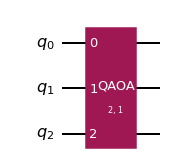

In [27]:
value_dict = {parameter: value for parameter, value in zip(qaoa.parameters, [1, 2])}
qaoa.bind_parameters(value_dict).draw("mpl", style="iqx")

In [28]:
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qaoa))
expectation = PauliExpectation().convert(expectation)

def energy(theta):
    value_dict = {parameter: theta[i] for i, parameter in enumerate(qaoa.parameters)}
    sampled = sampler.convert(expectation, params=value_dict)
    return np.real(sampled.eval())

In [29]:
energy([1, 2])

-1.4052734374999998

### Training the model

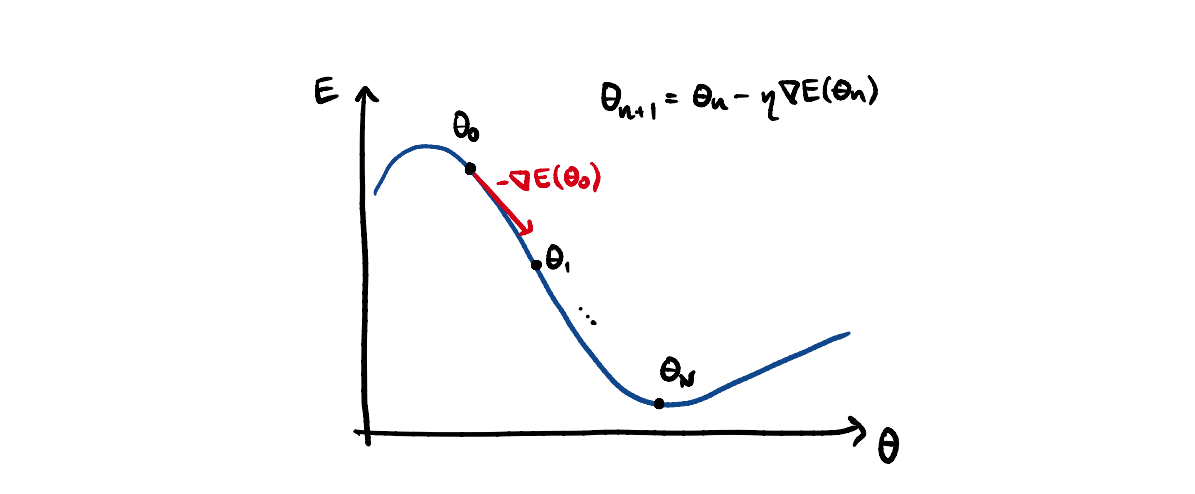

In [30]:
betas = gammas = np.linspace(-np.pi, np.pi, 200)
landscape = [[exact_energy([beta, gamma]) for beta in betas] for gamma in gammas]

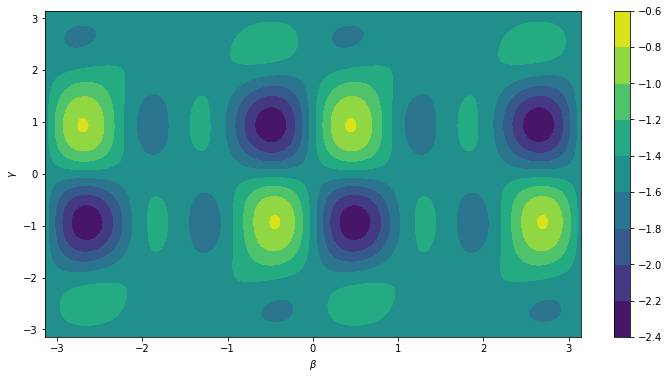

In [31]:
import matplotlib.pyplot as plt

X, Y = np.meshgrid(betas, gammas)
plt.figure(figsize=(12, 6))
plt.contourf(X, Y, landscape)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.colorbar()

In [32]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=100)

initial_parameters = np.arange(2)
result = optimizer.minimize(exact_energy, initial_parameters)

In [33]:
print(result)

{   'fun': -2.338885539357427,
    'jac': None,
    'nfev': 200,
    'nit': None,
    'njev': None,
    'x': array([-0.49141067,  0.93992111])}


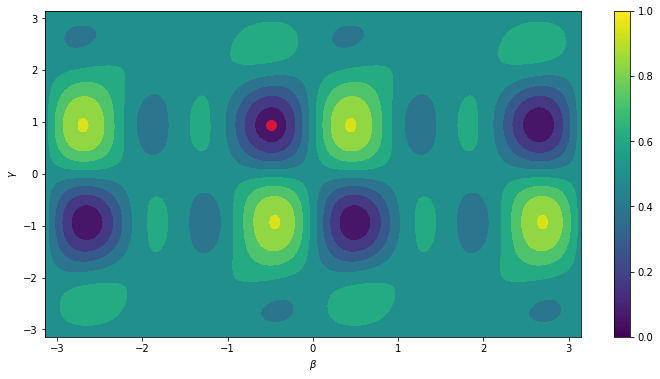

In [34]:
X, Y = np.meshgrid(betas, gammas)
plt.figure(figsize=(12, 6))
plt.contourf(X, Y, landscape)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.scatter(result.x[0], result.x[1], s=100, color="crimson")
plt.colorbar()

In [35]:
print("Number of circuit executions:", result.nfev)

Number of circuit executions: 200


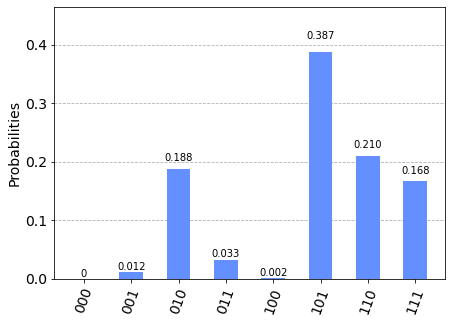

In [37]:
from qiskit.visualization import plot_histogram

final_state = Statevector(qaoa.bind_parameters(result.x))
probabilities = final_state.probabilities_dict()

plot_histogram(probabilities)

### Shot-based simulator

In [38]:
optimizer = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.1)

initial_parameters = np.arange(2)
result = optimizer.minimize(energy, initial_parameters)

In [39]:
betas = gammas = np.linspace(-np.pi, np.pi, 200)
shot_landscape = [[energy([beta, gamma]) for beta in betas] for gamma in gammas]

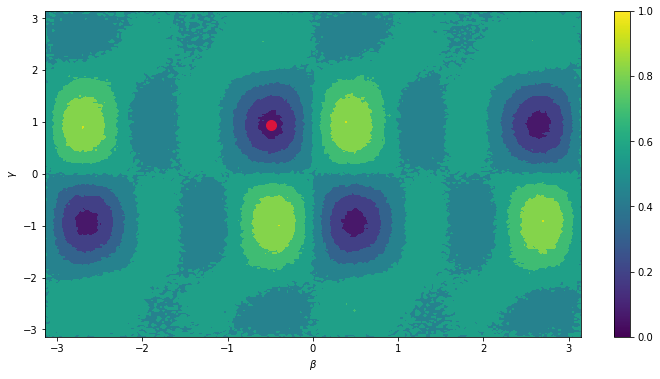

In [40]:
X, Y = np.meshgrid(betas, gammas)
plt.figure(figsize=(12, 6))
plt.contourf(X, Y, shot_landscape)
plt.scatter(result.x[0], result.x[1], s=100, color="crimson")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.colorbar()

In [41]:
# you can set this value also directly, but here we dig a bit to get it
num_shots = sampler.quantum_instance.run_config.shots

# we have a diagonal hamiltonian
num_bases = 1

print("Energy evaluations:", result.nfev)
print("Bases per evaluation:", num_bases)
print("Total number of circuit runs:", result.nfev * num_bases * num_shots)

Energy evaluations: 600
Bases per evaluation: 1
Total number of circuit runs: 614400


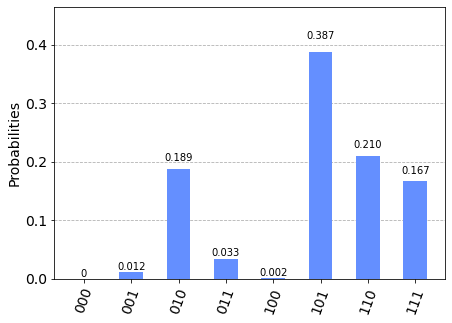

In [42]:
final_state = Statevector(qaoa.bind_parameters(result.x))
probabilities = final_state.probabilities_dict()

plot_histogram(probabilities)

### How could we improve?

We could increase the depth

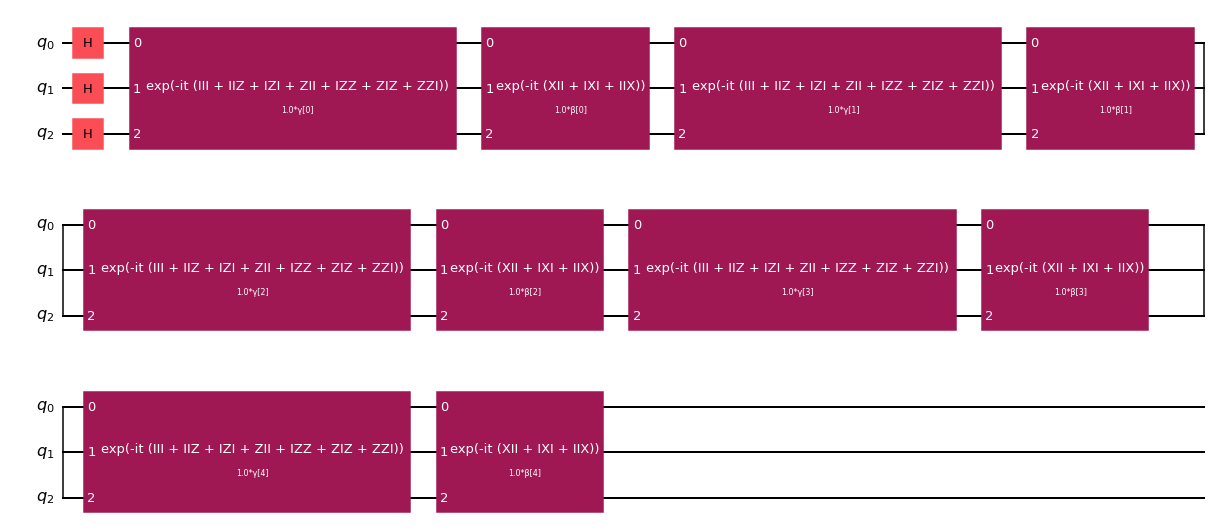

In [65]:
qaoa = QAOAAnsatz(hamiltonian, reps=5)

def exact_energy(theta):
    bound = qaoa.bind_parameters(theta)
    return np.real(Statevector(bound).expectation_value(hamiltonian.primitive))

qaoa.decompose().draw("mpl", style="iqx")

In [45]:
from qiskit.algorithms.optimizers import L_BFGS_B

optimizer = L_BFGS_B()
initial_parameters = np.random.random(qaoa.num_parameters)
result = optimizer.minimize(exact_energy, initial_parameters)

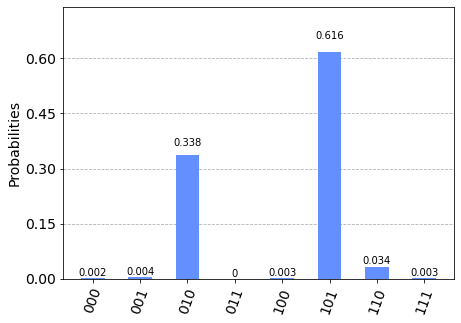

In [46]:
final_state = Statevector(qaoa.bind_parameters(result.x))
probabilities = final_state.probabilities_dict()

plot_histogram(probabilities)

We could change the ansatz!

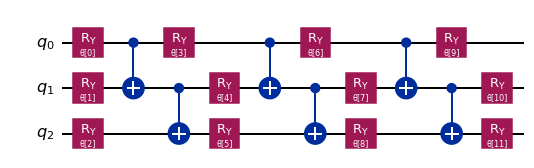

In [47]:
ansatz = RealAmplitudes(3, reps=3, entanglement="linear")
ansatz.decompose().draw("mpl", style="iqx")

In [48]:
def exact_energy(theta):
    bound = ansatz.bind_parameters(theta)
    return np.real(Statevector(bound).expectation_value(hamiltonian.primitive))

In [49]:
optimizer = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.1)

initial_parameters = np.arange(ansatz.num_parameters)
result = optimizer.minimize(exact_energy, initial_parameters)

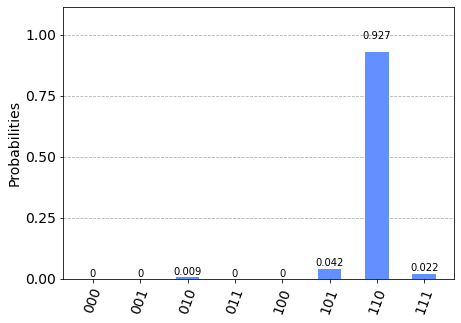

In [50]:
final_state = Statevector(ansatz.bind_parameters(result.x))
probabilities = final_state.probabilities_dict()

plot_histogram(probabilities)

Some more improvements:

* We could also just take into account the best $\alpha$ fraction of measurements!
* We could start from an annealing schedule and exploit QAOA's origin!

## Compilation for a real device

In [51]:
from qiskit.test.mock import FakeQuito

backend = FakeQuito()

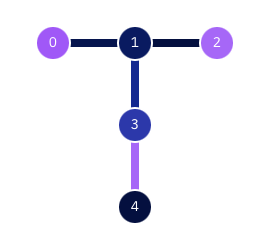

*ibmq_quito*

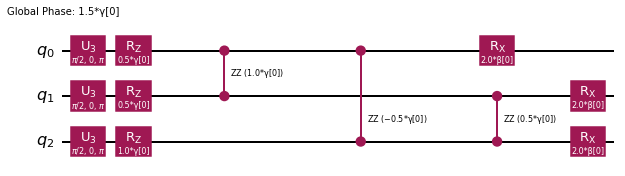

In [58]:
qaoa = QAOAAnsatz(hamiltonian, reps=1)
qaoa.decompose().decompose().decompose().draw("mpl", style="iqx")

In [59]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

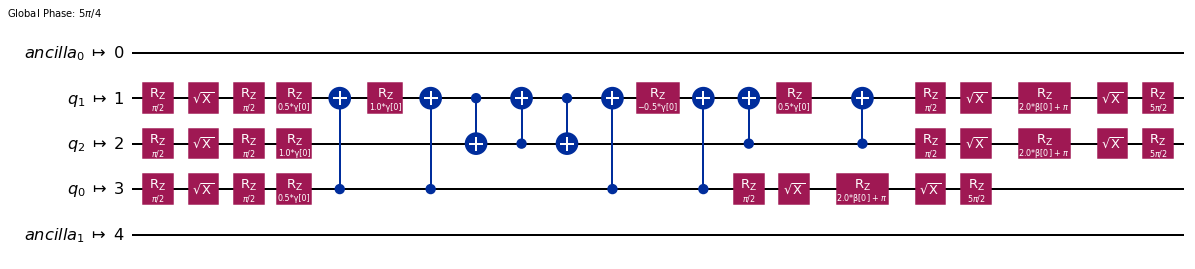

In [60]:
transpiled = transpile(qaoa, backend, optimization_level=3)
transpiled.draw("mpl", style="iqx")

We have additional SWAP gates since qubits 0 and 2 are not connected on the hardware!

In [61]:
transpiled.count_ops()

OrderedDict([('rz', 21), ('sx', 9), ('cx', 9)])

*Very rough* estimate on how good the measurements are:

In [62]:
cx_fidelity = 1 - 1.12e-2
num_cx = transpiled.count_ops()["cx"]
total_cx_fidelity = cx_fidelity ** num_cx

print(f"Estimated fidelity after {num_cx} CX:", total_cx_fidelity)

Estimated fidelity after 9 CX: 0.903599786641896


How could we avoid additional SWAP gates?

#### Duration in pulse-lengths

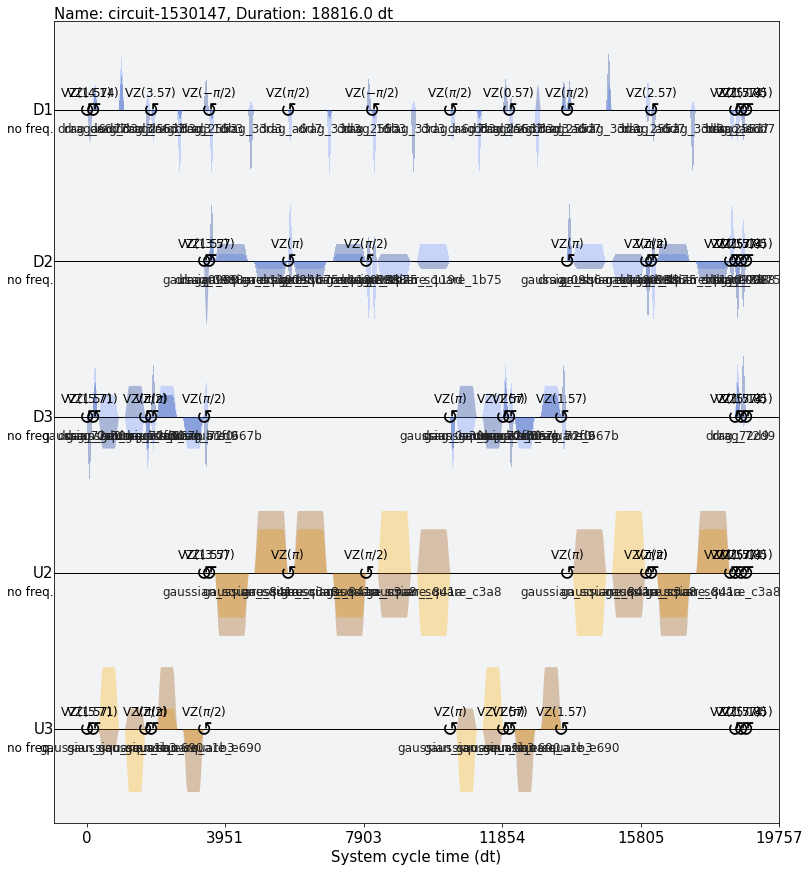

In [63]:
from qiskit import schedule

values = [1, 2]
bound = transpiled.bind_parameters(values)
schedule(bound, backend).draw()